In [1]:
from kernelforge._fchl19 import flocal_kernel, generate_fchl_acsf, generate_fchl_acsf_and_gradients, flocal_kernel_symm, fatomic_local_gradient_kernel
# import kernelforge
# help(kernelforge._fchl19)
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [2]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
elements=[1, 6, 8]
n_test = 100

In [3]:
Y = train["E"].flatten()
offset = np.mean(Y)
Y -= offset
Yt = test["E"].flatten()[:n_test] - offset

Yft = test["F"][:n_test].flatten()

In [5]:
X = np.asarray([generate_fchl_acsf(r, train["z"], elements=elements) for r in tqdm(train["R"])])
dX = np.asarray([generate_fchl_acsf_and_gradients(r, train["z"], elements=elements)[1] for r in tqdm(train["R"])])
dX.resize(1000,9,312,27)
print(dX.shape)
Q = np.asarray([train["z"] for r in train["R"]])
N = np.asarray([len(train["z"]) for r in train["R"]])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 9, 312, 27)


In [6]:
Xt = np.asarray([generate_fchl_acsf(r, test["z"], elements=elements) for r in tqdm(test["R"][:n_test])])
print(Xt.shape)
dXt = np.asarray([generate_fchl_acsf_and_gradients(r, test["z"], elements=elements)[1] for r in tqdm(test["R"])])
dXt.resize(n_test,9,312,27)
print(dXt.shape)
Qt = np.asarray([train["z"] for r in test["R"][:n_test]])
Nt = np.asarray([len(train["z"]) for r in test["R"][:n_test]])

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 9, 312)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 9, 312, 27)


In [7]:
print(Q.shape)

(1000, 9)


In [8]:
sigma = 2
t0 = time.perf_counter()
# K = flocal_kernel_symm(X, Q, N, sigma)
K = flocal_kernel(X, X, Q, Q, N, N, sigma)

t1 = time.perf_counter()
print(t1-t0)

0.19720519302063622


In [9]:
print(K[:5, :5])

[[36.56205673 36.18353264 36.38832142 36.75741247 36.59730816]
 [36.18353264 36.05427466 36.10143915 36.4471952  36.28464488]
 [36.38832142 36.10143915 36.40329634 36.60667564 36.42631773]
 [36.75741247 36.4471952  36.60667564 37.13615363 36.90021563]
 [36.59730816 36.28464488 36.42631773 36.90021563 36.74719399]]


In [10]:
from kernelforge._kernels import solve_cholesky

In [11]:
K_solve = K.copy()
for i in range(K_solve.shape[0]):
    K_solve[i,i] += 1e-8
alphas = solve_cholesky(K_solve, Y)
alphas

array([-1.31414412e+05,  4.10049342e+04, -8.71672311e+04, -1.07719808e+05,
        1.52983994e+05,  7.31251870e+04,  2.42718973e+05, -6.27991800e+05,
        8.76152819e+04, -1.17395717e+05, -8.55331106e+04,  2.37550035e+05,
       -7.49724138e+04, -5.60236766e+03,  5.94161559e+04, -1.25270205e+05,
        3.47603320e+04, -2.61758930e+05,  1.79847659e+05, -3.30484372e+05,
        1.32649210e+05,  3.24798414e+04, -1.15498152e+05,  1.55339889e+05,
       -4.18562236e+05, -2.26166530e+05,  1.26712829e+05, -4.59071417e+04,
        6.24808902e+04, -3.46105150e+05, -2.87316308e+05,  1.08915201e+04,
       -1.15537640e+05, -6.60817344e+04,  4.64264443e+02,  1.11972940e+05,
        2.20707512e+05, -2.57719368e+05, -2.89539668e+05, -7.17896709e+04,
        1.58779880e+05, -2.73773435e+05,  6.09238251e+04, -5.85517929e+04,
        7.29473216e+04,  1.64066969e+05, -7.99282046e+04,  4.88153413e+04,
       -9.85437495e+03, -2.64115401e+04,  2.72597843e+05, -6.37952347e+04,
        7.80135296e+04, -

In [12]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [13]:
t0 = time.perf_counter()
Kt = flocal_kernel(Xt, X, Qt, Q, Nt, N, sigma)
t1 = time.perf_counter()
print(t1-t0)

0.045360224990872666


In [14]:
Yp = Kt @ alphas

RMSE = 0.2352648605293976
PearsonRResult(statistic=np.float64(0.9986700458476816), pvalue=np.float64(5.129752955330032e-128))


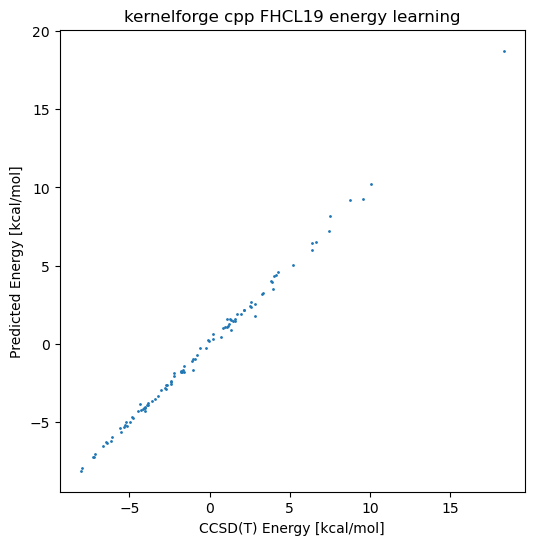

In [15]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yp, Yt)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.title("kernelforge cpp FHCL19 energy learning")
plt.scatter(Yt, Yp, s=1)

In [16]:
os.environ["OMP_NUM_THREADS"] = ""
os.environ["MKL_NUM_THREADS"] = ""
t0 = time.perf_counter()

Kd = fatomic_local_gradient_kernel(X, Xt, dXt, Q, Qt, N, Nt, sigma).T
t1 = time.perf_counter()
print(t1-t0)

5.183936773013556


In [ ]:
Kd.shape

In [ ]:
Yfp = Kd @ alphas
Yfp.shape

In [ ]:
Yft.shape

In [ ]:
rmse = np.sqrt(np.mean(np.square(Yft - Yfp)))
res = pearsonr(Yfp, Yft)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol/Å]")
plt.ylabel("Predicted Energy [kcal/mol/Å]")
plt.title("kernelforge cpp FHCL19 energy learning")
plt.scatter(Yft, Yfp, s=1)